Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

# Wrangle ML datasets (From 231 assignment)
[ ] Continue to clean and explore your data.

[ ] For the evaluation metric you chose, what score would you get just by guessing?

[ ] Can you make a fast, first model that beats guessing?

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

# Uploading Data Set

In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('/Users/bradbrauser/Desktop/Data Science/MoviesOnStreamingPlatforms_updated.csv')

In [3]:
df.shape

(16744, 17)

# Which column in your tabular dataset will you predict, and how is your target distributed?

The dataset has two rating features - IMDb and Rotten Tomatoes.

IMDb is great for seeing what general audiences think of a movie. If you don’t care what the critics say and want to see what people like yourself think of a movie, then you should use IMDb. Just be aware that fans often skew the vote with 10-star ratings, which may inflate scores somewhat.

Rotten Tomatoes offers the best overall picture of whether a movie is worth seeing at a glance. If you only trust the opinions of top critics and just want to know if a movie is at least decent, you should use Rotten Tomatoes. While the Fresh/Rotten binary can oversimplify the often complex opinions of critics, it should still help you weed out lousy films.

My goal with this project is more in line with IMDb, as even though scores may be skewed a bit by fans of the movies, I still want to know what the public thinks, because it seems that more often than not critics do not always line up with the public opinion.

In [4]:
print(df['IMDb'].isnull().sum())
print(df['Rotten Tomatoes'].isnull().sum())

571
11586


In [5]:
# Since the Rotten Tomatoes features has over 11,000 missing ratings, 
# I'm going to just drop the Rotten Tomatoes column

df = df.drop(['Rotten Tomatoes'], axis = 1)
df.head()

,Unnamed: 0,ID,Title,Year,Age,IMDb,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,0,1,Inception,2010,13+,8.8,1,0,0,0,0,Christopher Nolan,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom","English,Japanese,French",148.0
1,1,2,The Matrix,1999,18+,8.7,1,0,0,0,0,"Lana Wachowski,Lilly Wachowski","Action,Sci-Fi",United States,English,136.0
2,2,3,Avengers: Infinity War,2018,13+,8.5,1,0,0,0,0,"Anthony Russo,Joe Russo","Action,Adventure,Sci-Fi",United States,English,149.0
3,3,4,Back to the Future,1985,7+,8.5,1,0,0,0,0,Robert Zemeckis,"Adventure,Comedy,Sci-Fi",United States,English,116.0
4,4,5,"The Good, the Bad and the Ugly",1966,18+,8.8,1,0,1,0,0,Sergio Leone,Western,"Italy,Spain,West Germany",Italian,161.0


In [6]:
df = df.dropna(subset=['IMDb'], how='all')
df['IMDb'].isnull().sum()

df.shape

(16173, 16)

In [9]:
def wrangle(df, thresh=500):
    df = df.copy()
    
    # Setting Title as index
    df.set_index(df['Year'], inplace = True)    
    
    # Dropping rows if nulls exist
    df.dropna(subset=['IMDb'], how='all')
    
    # Creating new Rating colums
    df['Good?'] = df['IMDb'] >= 7.0
        
    # Dropping unnecessary values
    df.drop(['Unnamed: 0', 'ID', 'Title', 'Type', 'ID', 'Year', 
             'Directors', 'Genres', 'Country', 'Language', 'IMDb'], 
            axis=1, inplace=True)
    
    # Split label and feature matrix
    y = df['Good?']
    df.drop(['Good?'], axis=1, inplace=True)
    
    return df, y

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Wrangling
X, y = wrangle(df)

print(X.shape)
print(y.shape)

# Train test split on years movies were released
cutoff = 2010
X_train, y_train = X[X.index < cutoff], y[y.index < cutoff]
X_val, y_val = X[X.index >= cutoff], y[y.index >= cutoff]

# Baseline
y_train.value_counts(normalize = True)

(16173, 6)
(16173,)


False    0.77432
True     0.22568
Name: Good?, dtype: float64

In [11]:
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

In [12]:
# Building model 1
model1 = Pipeline([
    ('oe', OrdinalEncoder()),
    ('impute', SimpleImputer()),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(criterion='entropy', 
                                          max_depth=50, n_estimators=200, 
                                          min_samples_leaf=1, 
                                          random_state=42))
])

# Fitting the model
model1.fit(X_train, y_train)

print('Training Accuracy:', model1.score(X_train, y_train))
print('Validation Accuracy:', model1.score(X_val, y_val))

Training Accuracy: 0.8352479278755272
Validation Accuracy: 0.6934165232358004


In [15]:
# Building model 2
model2 = Pipeline([
                  ('ohe', OneHotEncoder()),
                  ('impute', SimpleImputer()),
                  ('scaler', StandardScaler()),
                  ('classifier', RandomForestClassifier(criterion='entropy', 
                                                        max_depth=50, n_estimators=200, 
                                                        min_samples_leaf=1, random_state=42))
])

# Fitting the model
model2.fit(X_train, y_train)

print('Training Accuracy:', model2.score(X_train, y_train))
print('Validation Accuracy:', model2.score(X_val, y_val))

Training Accuracy: 0.8352479278755272
Validation Accuracy: 0.6970740103270223


In [16]:
# Model 3
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

model3 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    StandardScaler(), 
    RandomForestClassifier(n_estimators = 10, min_samples_split = 40))

# Fitting the model
model3.fit(X_train, y_train)

print('Training Accuracy:', model3.score(X_train, y_train))
print('Validation Accuracy:', model3.score(X_val, y_val))

Training Accuracy: 0.7948233241238912
Validation Accuracy: 0.7389199655765921


In [18]:
# Model 5
model5 = make_pipeline(
  OrdinalEncoder(),
  SimpleImputer(strategy='median'),
  StandardScaler(),
  RandomForestClassifier(
      min_samples_split=3,
      max_depth=15,
      n_estimators= 200,
      n_jobs=1)
)

param_distributions = {
    'randomforestclassifier__criterion': ('entropy'),
#     'randomforestclassifier__max_depth' : (11, 12, 13, 14, 15),
#     'randomforestclassifier__min_samples_split': (2),
}

search = RandomizedSearchCV(
    model5,
    param_distributions=param_distributions,
    n_iter=40,
    cv=7,
    scoring='accuracy',
    verbose = 30,
    return_train_score=True,
    n_jobs=4,
)

search.fit(X_train, y_train)

print('Cross-validation Best Score:', search.best_score_)
print('Best Estimator:', search.best_params_)
print('Best Model:', search.best_estimator_)

/Users/bradbrauser/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 7 is smaller than n_iter=40. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1071s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.1s


Fitting 7 folds for each of 7 candidates, totalling 49 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  20 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  22 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  30 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  32 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Do

KeyError: 'e'

In [19]:
from xgboost import XGBClassifier

model6 = make_pipeline(ce.OrdinalEncoder(),
                         XGBClassifier(n_estimators=100,
                                       random_state=42,
                                       n_jobs=-1)
)

model6.fit(X_train, y_train)

print('Training Accuracy:', model6.score(X_train, y_train))
print('Validation Accuracy:', model6.score(X_val, y_val))

Training Accuracy: 0.8098007852261161
Validation Accuracy: 0.732250430292599


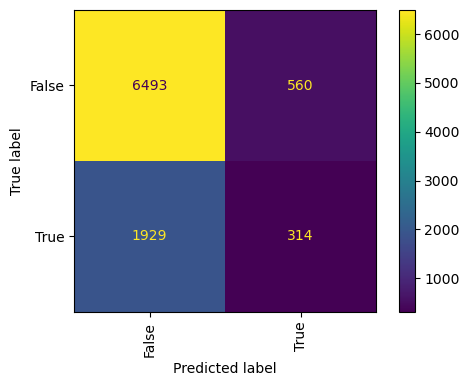

In [20]:
from sklearn.metrics import plot_confusion_matrix, classification_report
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 100
plot_confusion_matrix(model6, X_val, y_val, values_format='.0f', xticks_rotation='vertical')

In [21]:
y_pred = model6.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.77      0.92      0.84      7053
        True       0.36      0.14      0.20      2243

    accuracy                           0.73      9296
   macro avg       0.57      0.53      0.52      9296
weighted avg       0.67      0.73      0.69      9296



In [22]:
import numpy as np

feature = 'Runtime'
print(X_val[feature].head())
print()
print(X_val[feature].value_counts())

X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val_permuted[feature])

acc = model6.score(X_val, y_val)
acc_permuted = model6.score(X_val_permuted, y_val)

print(f'Validation accuracy with {feature}:', acc)
print(f'Validation accuracy with {feature} permuted:', acc_permuted)
print(f'Permutation importance:', acc - acc_permuted)

Year
2010    148.0
2018    149.0
2018    117.0
2012    165.0
2015    118.0
Name: Runtime, dtype: float64

90.0     560
95.0     272
92.0     247
85.0     245
89.0     235
        ... 
197.0      1
16.0       1
256.0      1
3.0        1
167.0      1
Name: Runtime, Length: 199, dtype: int64
Validation accuracy with Runtime: 0.732250430292599
Validation accuracy with Runtime permuted: 0.7030981067125646
Permutation importance: 0.02915232358003439


In [23]:
import eli5
from eli5.sklearn import PermutationImportance

# Ignore warnings

transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)



feature_names = X_val.columns.tolist()

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

/Users/bradbrauser/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/bradbrauser/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.0311 ± 0.0047,Runtime
0.0067 ± 0.0024,Prime Video
0.0049 ± 0.0024,Age
0.0037 ± 0.0009,Disney+
-0.0028 ± 0.0033,Netflix
-0.0060 ± 0.0019,Hulu
